In [1]:
import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
if project_root not in sys.path:
    sys.path.append(project_root)

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import albumentations as A
import cv2 
from PIL import Image 
import random 

# Importamos las funciones necesarias de visualization_utils
from src.visualization_utils import plot_full_hierarchical_distribution, plot_all_augmentations 

PROCESSED_DATA_PATH = '../data/processed/'
RAW_DATA_PATH = '../data/raw/'
IMAGE_ROOT_DIR = os.path.join(RAW_DATA_PATH, 'color')

# Cargar el DataFrame splitted
df_splitted_path = os.path.join(PROCESSED_DATA_PATH, 'dataframe_splitted.csv')
if not os.path.exists(df_splitted_path):
    raise FileNotFoundError(f"Error: El archivo '{df_splitted_path}' no se encontró. Ejecuta '1_exploracion_y_split.ipynb' primero.")

df_splitted = pd.read_csv(df_splitted_path)
print(f"DataFrame 'dataframe_splitted.csv' cargado con {len(df_splitted)} imágenes.")
print("Primeras 5 filas:")
print(df_splitted.head())

# Obtener las etiquetas de clase
num_classes = df_splitted['class'].nunique()
class_labels = sorted(df_splitted['class'].unique())
print(f"Número de clases: {num_classes}")
print(f"Clases: {class_labels}")

# Separar los conjuntos de datos
train_df = df_splitted[df_splitted['split'] == 'train'].reset_index(drop=True)
val_df = df_splitted[df_splitted['split'] == 'valid'].reset_index(drop=True)
test_df = df_splitted[df_splitted['split'] == 'test'].reset_index(drop=True)

print(f"Tamaño del conjunto de entrenamiento: {len(train_df)}")
print(f"Tamaño del conjunto de validación: {len(val_df)}")
print(f"Tamaño del conjunto de test: {len(test_df)}")


2025-06-10 19:43:54.204675: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-10 19:43:54.215956: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749595434.228777   27998 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749595434.232590   27998 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749595434.242875   27998 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

DataFrame 'dataframe_splitted.csv' cargado con 54305 imágenes.
Primeras 5 filas:
                                       relative_path                    class  \
0  Tomato___Bacterial_spot/349e804d-2b74-4d13-8a4...  Tomato___Bacterial_spot   
1  Tomato___Bacterial_spot/022e8a4a-9297-4de3-88a...  Tomato___Bacterial_spot   
2  Tomato___Bacterial_spot/f5d9fa8d-af44-4362-913...  Tomato___Bacterial_spot   
3  Tomato___Bacterial_spot/f44c58b0-4d48-4b8b-b81...  Tomato___Bacterial_spot   
4  Tomato___Bacterial_spot/99187376-a5c2-41a7-9eb...  Tomato___Bacterial_spot   

    group             tag                                          full_path  \
0  Tomato  Bacterial_spot  ../data/raw/color/Tomato___Bacterial_spot/349e...   
1  Tomato  Bacterial_spot  ../data/raw/color/Tomato___Bacterial_spot/022e...   
2  Tomato  Bacterial_spot  ../data/raw/color/Tomato___Bacterial_spot/f5d9...   
3  Tomato  Bacterial_spot  ../data/raw/color/Tomato___Bacterial_spot/f44c...   
4  Tomato  Bacterial_spot  ../da

### Aumento de dato con albumentations


--- Visualizando Original, Aumentación Conservadora e Intensiva para 5 muestras: ---


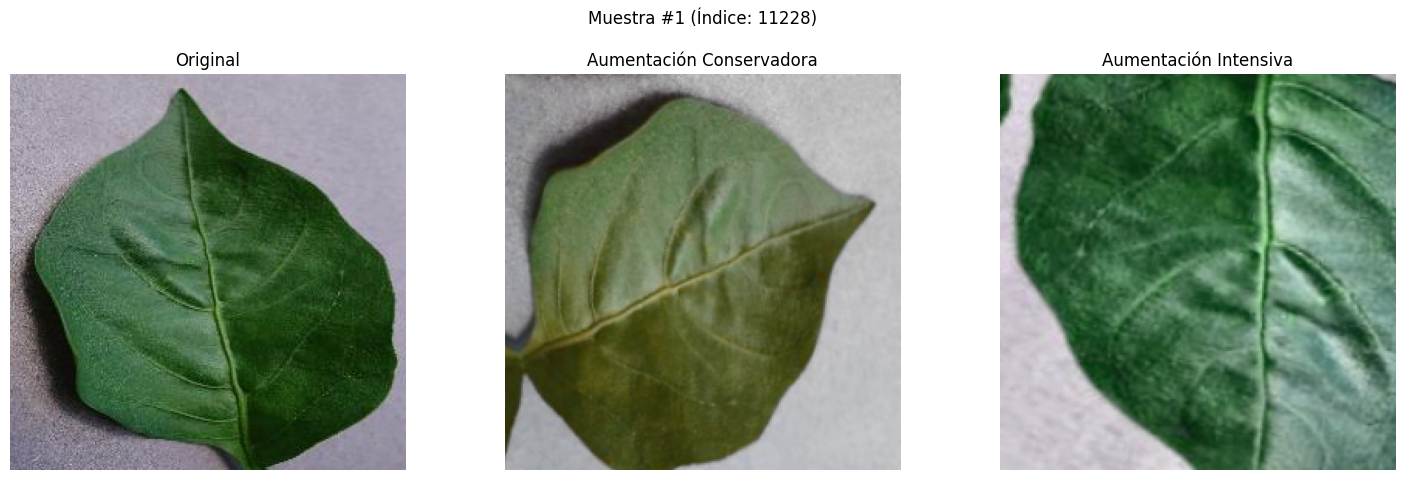

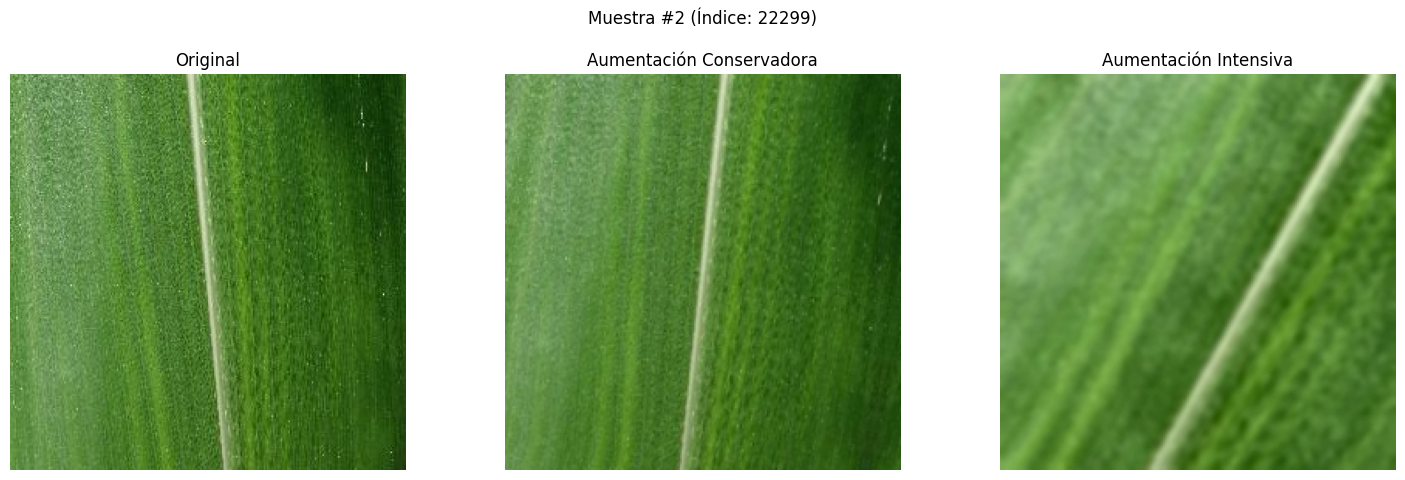

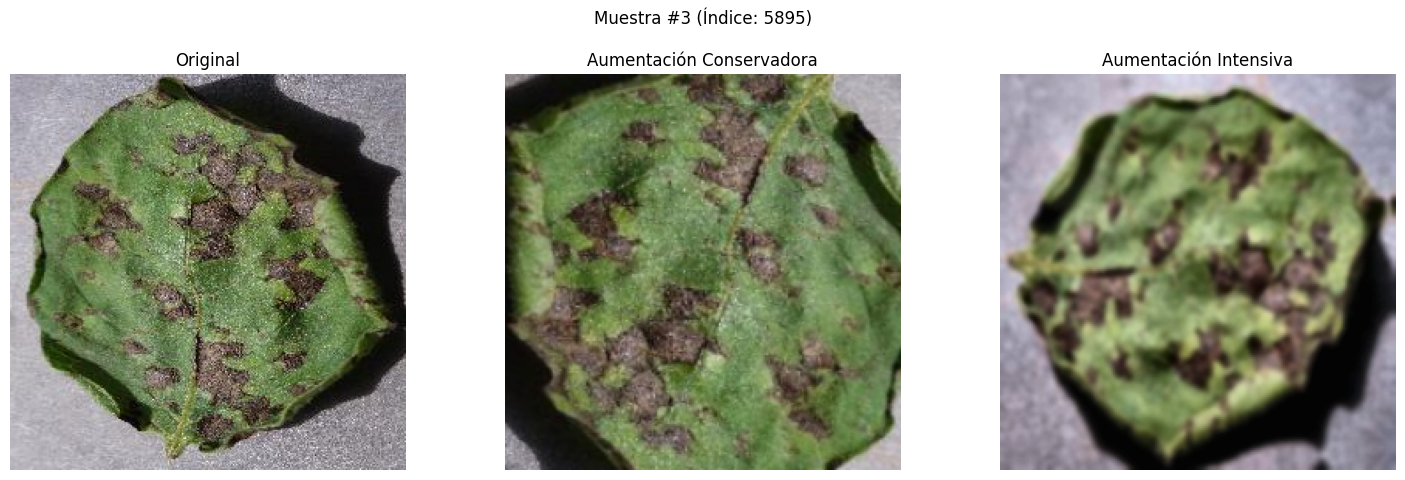

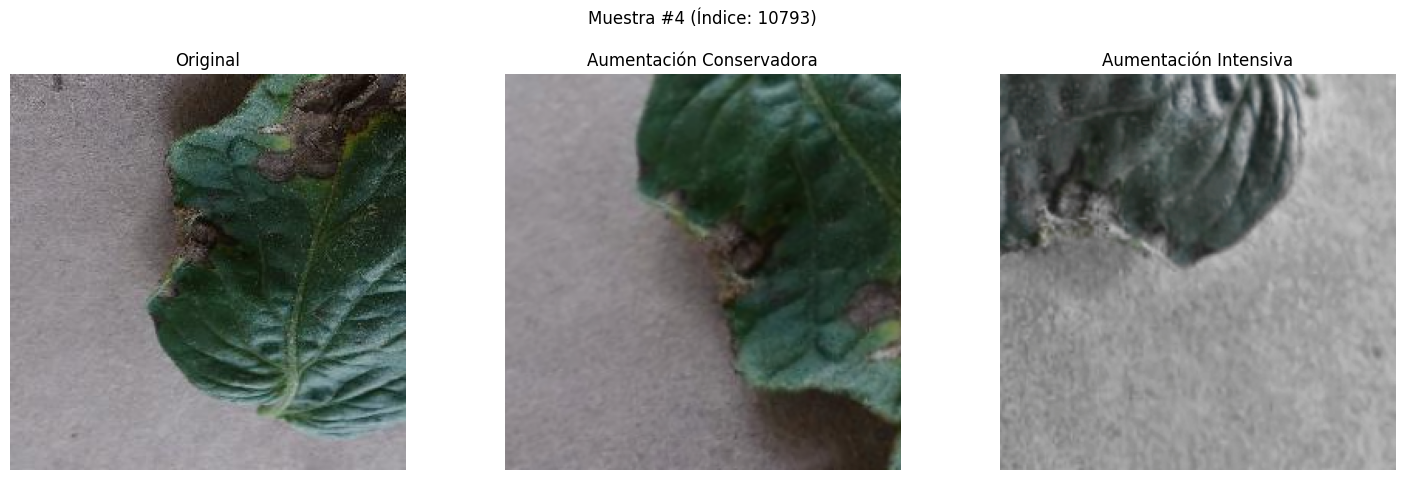

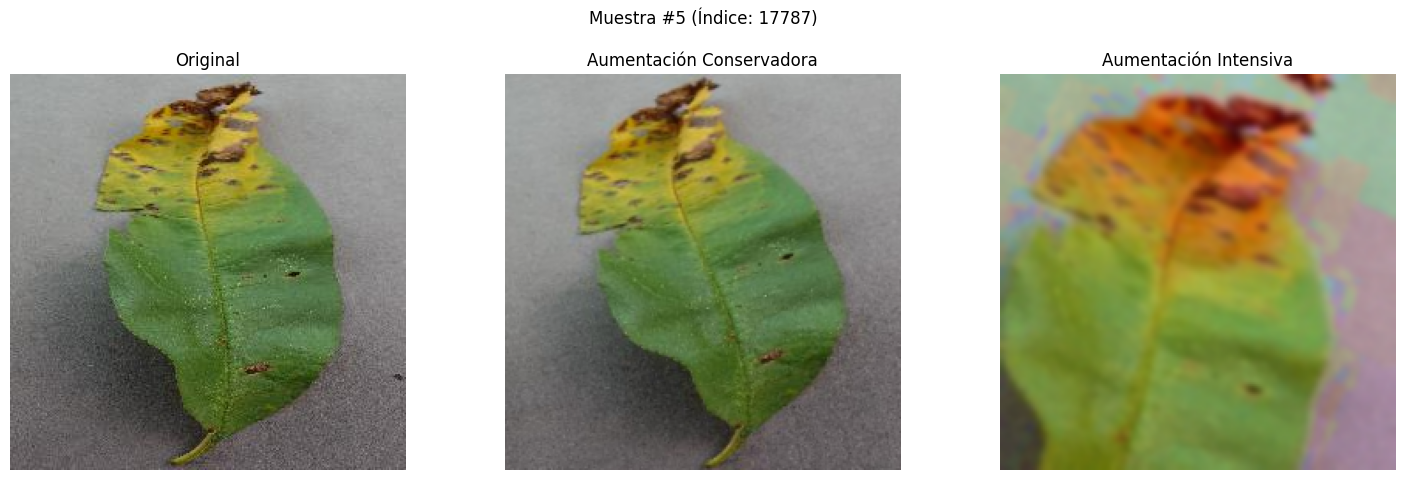

In [2]:
# Estrategia de aumentación Conservadora
transform_conservative = A.Compose([
    A.Rotate(limit=180, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomScale(scale_limit=0.1, p=0.3),
    A.RandomCrop(width=200, height=200, p=0.3),
    A.Resize(224, 224), 
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.3),
    A.GaussianBlur(blur_limit=(3, 5), p=0.2),
])

# Estrategia de aumentación Intensiva
mult = 2
scaler = 1.5
transform_intensive = A.Compose([
    A.Rotate(limit=180, p=0.5 * mult),
    A.HorizontalFlip(p=0.5 * mult),
    A.VerticalFlip(p=0.5 * mult),

    A.RandomCrop(width=180, height=180, p=0.6),
    A.Resize(224, 224), 

    A.RandomBrightnessContrast(brightness_limit=0.1 * scaler, contrast_limit=0.1 * scaler, p=0.4), # Más fuerte
    A.HueSaturationValue(hue_shift_limit=15 * scaler, sat_shift_limit=30 * scaler, val_shift_limit=15 * scaler, p=0.4), # Más fuerte
    A.GaussNoise(p=0.2),
    A.GaussianBlur(blur_limit=(7, 9), p=0.5), # Más intenso
    A.RandomScale(scale_limit=0.1, p=0.9*mult), 
    A.CLAHE(clip_limit=2.0, p=0.8), # Casi siempre aplicada
])

# --- Funciones Auxiliares para Carga y Transformación (se quedan aquí) ---

def load_image_np(filepath):
    """Carga una imagen y la devuelve como array NumPy (PIL por defecto carga como RGB)."""
    img_pil = Image.open(filepath).convert("RGB")
    return np.array(img_pil)

def apply_transformation_direct(original_image_array: np.ndarray, transformation_pipeline: A.Compose) -> np.ndarray:
    """
    Aplica una transformación de Albumentations directamente a una imagen NumPy.
    Asume que la imagen de entrada es en formato uint8 [0, 255].
    """
    transformed = transformation_pipeline(image=original_image_array)
    return transformed['image']

# --- Visualización de Imágenes Original, Conservadora e Intensiva (Ahora llamando a la función importada) ---
plot_all_augmentations(dataframe=train_df, 
                       image_root_dir=IMAGE_ROOT_DIR,
                       transform_conservative_pipeline=transform_conservative,
                       transform_intensive_pipeline=transform_intensive,
                       load_image_fn=load_image_np,       # Pasamos la función definida en este script
                       apply_transform_fn=apply_transformation_direct, # Pasamos la función definida en este script
                       num_samples=5)


In [3]:
# Wrapper para Albumentations (para ImageDataGenerator)
def apply_albumentations_for_datagen(image_array, alb_transform):
    """
    Recibe una imagen (array NumPy) en rango [0, 1] (normalizada por ImageDataGenerator),
    la convierte a [0, 255] uint8 para Albumentations, aplica la transformación,
    y devuelve la imagen nuevamente en rango [0, 1] float32.
    """
    image_uint8 = (image_array * 255).astype(np.uint8)
    augmented_image = alb_transform(image=image_uint8)['image']
    return augmented_image.astype(np.float32) / 255.0

# Generador para entrenamiento conservador (usa transform_conservative)
datagen_conservative = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=lambda x: apply_albumentations_for_datagen(x, transform_conservative)
)

# Generador para entrenamiento intensivo (usa transform_intensive)
datagen_intensive = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=lambda x: apply_albumentations_for_datagen(x, transform_intensive)
)

# Generador para validación y test (solo normalización)
datagen_val_test = ImageDataGenerator(rescale=1./255)

# Creación de los Generadores de Datos
TARGET_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

train_generator_conservative = datagen_conservative.flow_from_dataframe(
    dataframe=train_df,
    directory=IMAGE_ROOT_DIR,
    x_col='relative_path',
    y_col='class',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

train_generator_intensive = datagen_intensive.flow_from_dataframe(
    dataframe=train_df,
    directory=IMAGE_ROOT_DIR,
    x_col='relative_path',
    y_col='class',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

val_generator = datagen_val_test.flow_from_dataframe(
    dataframe=val_df,
    directory=IMAGE_ROOT_DIR,
    x_col='relative_path',
    y_col='class',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = datagen_val_test.flow_from_dataframe(
    dataframe=test_df,
    directory=IMAGE_ROOT_DIR,
    x_col='relative_path',
    y_col='class',
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print("\n--- Generadores de Datos Creados (Para Entrenamiento de Modelo) ---")
print(f"train_generator_conservative: Encontradas {train_generator_conservative.samples} imágenes.")
print(f"train_generator_intensive: Encontradas {train_generator_intensive.samples} imágenes.")
print(f"val_generator: Encontradas {val_generator.samples} imágenes.")
print(f"test_generator: Encontradas {test_generator.samples} imágenes.")


Found 38013 validated image filenames belonging to 38 classes.
Found 38013 validated image filenames belonging to 38 classes.
Found 5431 validated image filenames belonging to 38 classes.
Found 10861 validated image filenames belonging to 38 classes.

--- Generadores de Datos Creados (Para Entrenamiento de Modelo) ---
train_generator_conservative: Encontradas 38013 imágenes.
train_generator_intensive: Encontradas 38013 imágenes.
val_generator: Encontradas 5431 imágenes.
test_generator: Encontradas 10861 imágenes.


### Distribución de clases

In [4]:
# Asumimos que 'train_df' y 'class_labels' ya fueron creados en tu script
print("--- Paso 1: Creando el DataFrame Balanceado en Memoria ---")

# Encontrar el número de muestras en la clase con más imágenes
max_samples_class = train_df['class'].value_counts().max()
print(f"La clase mayoritaria tiene {max_samples_class} muestras. Se balanceará a este número.")

# Crear un DataFrame vacío para guardar el resultado
balanced_train_df = pd.DataFrame()

# Aplicar sobremuestreo (oversampling)
for class_name in class_labels:
    class_df = train_df[train_df['class'] == class_name]
    # Usamos .sample() con replace=True para duplicar las imágenes hasta alcanzar el máximo
    oversampled_class_df = class_df.sample(
        n=max_samples_class,
        replace=True,
        random_state=42
    )
    balanced_train_df = pd.concat([balanced_train_df, oversampled_class_df], ignore_index=True)

# Mezclar el dataframe final para que las clases no queden ordenadas
balanced_train_df = balanced_train_df.sample(frac=1, random_state=42).reset_index(drop=True)

print(f"\nEl DataFrame balanceado tiene un total de {len(balanced_train_df)} filas.")
print("Verificando el balanceo (primeras 5 clases):")
print(balanced_train_df['class'].value_counts().head())


--- Paso 1: Creando el DataFrame Balanceado en Memoria ---
La clase mayoritaria tiene 3854 muestras. Se balanceará a este número.

El DataFrame balanceado tiene un total de 146452 filas.
Verificando el balanceo (primeras 5 clases):
class
Potato___healthy                       3854
Corn_(maize)___Northern_Leaf_Blight    3854
Cherry_(including_sour)___healthy      3854
Potato___Late_blight                   3854
Tomato___Early_blight                  3854
Name: count, dtype: int64


Creando DataFrame de entrenamiento balanceado...
DataFrame balanceado creado con 146452 muestras.


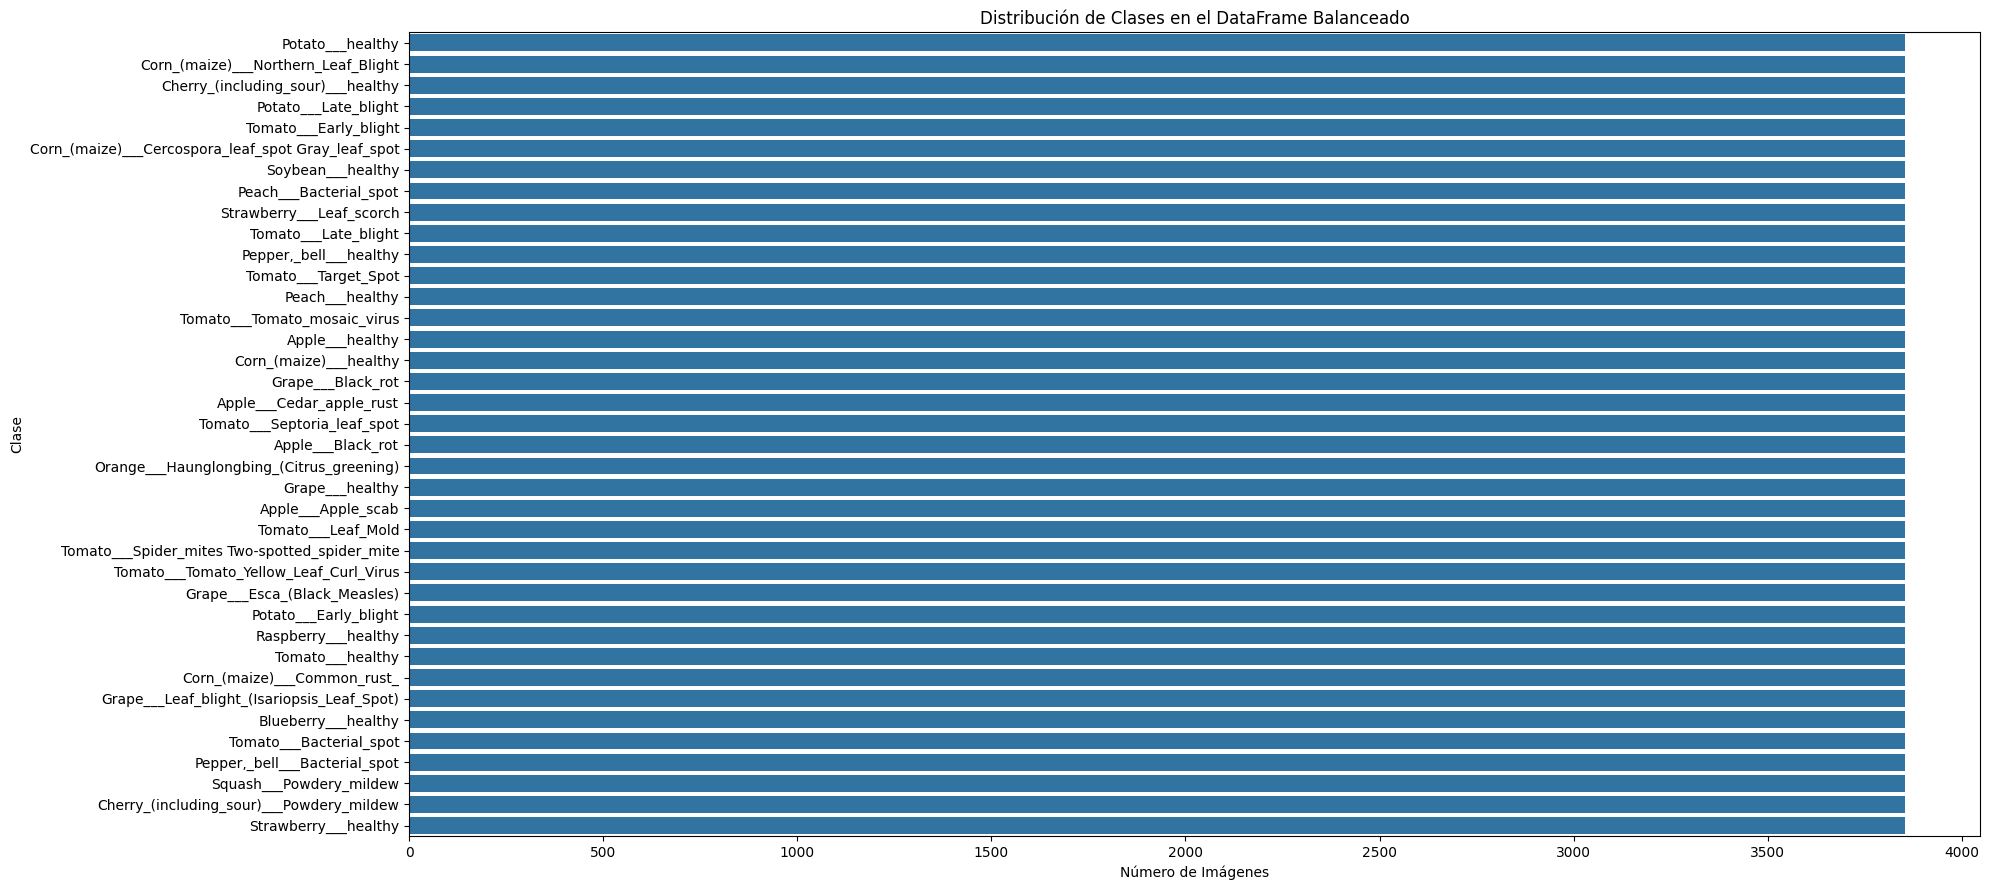

In [7]:
import seaborn as sns
# --- 3. BALANCEO DE CLASES POR SOBREMUESTREO ---
print("Creando DataFrame de entrenamiento balanceado...")

max_samples = train_df['class'].value_counts().max()
balanced_train_df = pd.concat([
    train_df[train_df['class'] == c].sample(n=max_samples, replace=True, random_state=42)
    for c in class_labels
]).sample(frac=1, random_state=42).reset_index(drop=True)

print(f"DataFrame balanceado creado con {len(balanced_train_df)} muestras.")

# --- Verificación Gráfica del Balanceo ---
plt.figure(figsize=(20, 9))
sns.countplot(data=balanced_train_df, y='class', order=balanced_train_df['class'].value_counts().index)
plt.title('Distribución de Clases en el DataFrame Balanceado')
plt.xlabel('Número de Imágenes')
plt.ylabel('Clase')
plt.tight_layout()
plt.show()

In [ ]:
output_path = os.path.join(PROCESSED_DATA_PATH, 'df_train_balanced.csv')

balanced_train_df.to_csv(output_path, index=False)

print(f"¡Éxito! El DataFrame de entrenamiento balanceado ha sido guardado en:")
print(output_path)

¡Éxito! El DataFrame de entrenamiento balanceado ha sido guardado en:
../data/processed/df_train_balanced.csv
